In [1]:
%matplotlib inline

# Volumetric Registration and Analysis
In this tutorial we align a CLARITY brain Control258 to the Allen Reference Atlas (ARA).  Thus the ARA is our _reference_ image, it consists of image data stored in the default "average" channel and corresponding annotations stored in a separate "annotation" channel.  We begin by importing the relevant modules

In [2]:
from ndreg import *
import matplotlib
import ndio.remote.neurodata as neurodata

Next we'll download the image data

In [3]:
refToken = "ara_ccf2"
refImg = imgDownload(refToken)

When given an image volume *imgShow* displays it as a set of evenly spaced z-slices (1st column), y-slices (2nd column) and x slices (3rd column).

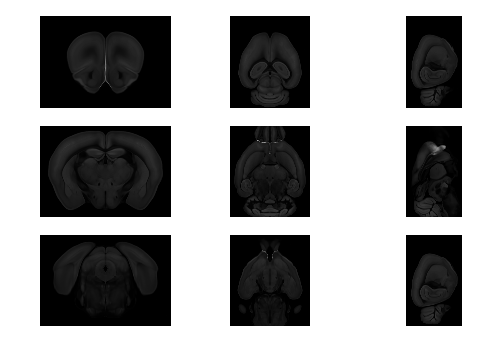

In [4]:
imgShow(refImg)

The displayed slices above are a little too dark.  So we set the visuilization max *vmax* manually.

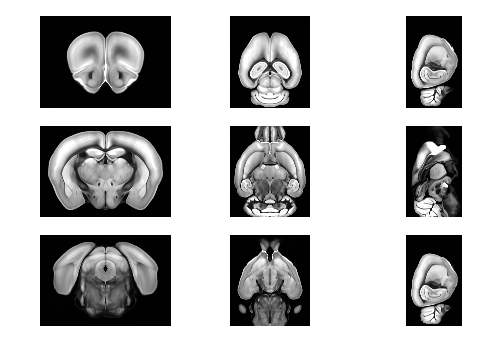

In [5]:
imgShow(refImg, vmax=500)

Now we download the atlas annotations.

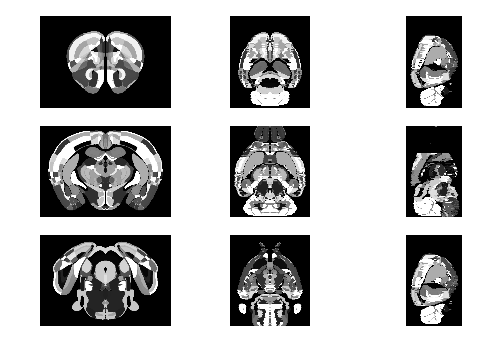

In [6]:
refAnnoImg = imgDownload(refToken, channel="annotation")
imgShow(refAnnoImg, vmax=1000)

It's usually better to visuaize a set of annotations in color.  Let's display the atlas annotations using a random colormap.  We begin by creating a 1000x3 array of random values.

In [7]:
randValues = np.random.rand(1000,3)

Since we always want the backgrond (label 0) to be black make the 0th row is [0,0,0].

In [8]:
randValues = np.concatenate(([[0,0,0]],randValues))

Now we can display the annotations.

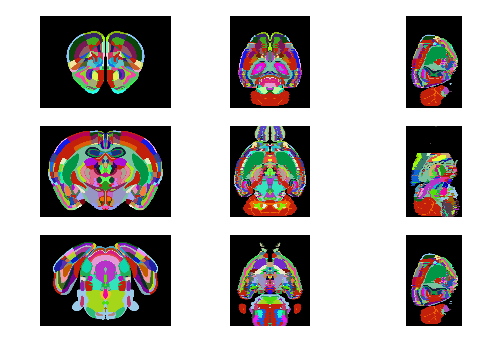

In [9]:
randCmap = matplotlib.colors.ListedColormap (randValues)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap)

Let's overlay these annotations on the atlas image using alpha transparency.  To do this we must set *newFig* to *False* so that matplotlib appends the annotation data to the current figure instead of creating new one.  

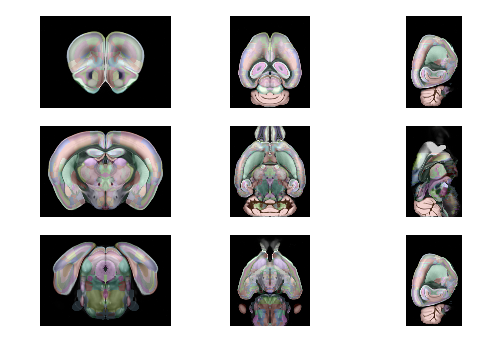

In [10]:
imgShow(refImg, vmax=500, newFig=False)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.2, newFig=False)
plt.show()

## Downloading CLARITY brain
Our *input* image will be CLARITY brain Control258.  At full resolution, CLARITY brains can be 1 Terabyte in size, far to large to be downloaded to a personal computer.  Thus *ndstore* stores the brains at multiple resolutions. Resolution 0 is always the highest resolution each subsequent resoltion takes up 1/4th (under slice scaling) or 1/8th (under isotropic scaling) as many bytes as the previous resoltion.  We can use ndio's get_metadata method to see a list of available resoltions.

In [11]:
inToken = "AutA"

nd = neurodata()
print(nd.get_metadata(inToken)['dataset']['voxelres'].keys())

[u'1', u'0', u'3', u'2', u'5', u'4']


Clearly resolution 5 is the lowest available resolution.  So we'll download the CLARITY image at that resolution.  Depending on your internet connection downloading may take several minutes.

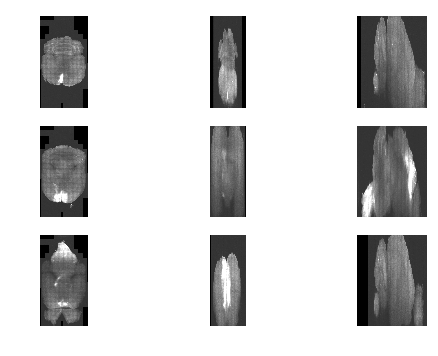

In [12]:
inImg = imgDownload(inToken, resolution=5)
imgShow(inImg, vmax=500)

Let's make a copy of the downloaded image.  We'll need to use it later

In [13]:
inImg_download = imgCopy(inImg)

## Resampling CLARITY image
Notice how the CLARITY brain's resolution is higher than the ARA image that we want to align it to.

In [14]:
print(inImg.GetSpacing())

(0.01872, 0.01872, 0.005)


In [15]:
print(refImg.GetSpacing())

(0.024999999999999998, 0.024999999999999998, 0.024999999999999998)


Since we are aliging the CLARITY image to a lower resolution atlas, we can save memory by downsampling it to the resolution atlas.

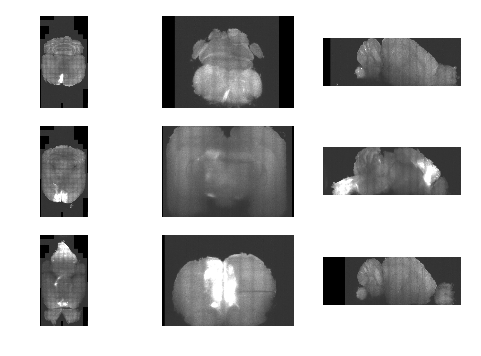

In [16]:
inImg = imgResample(inImg, spacing=refImg.GetSpacing())
imgShow(inImg, vmax=500)

## Reorienting CLARITY image
You may have noticed that the CLARITY brain is not oriented in the same way as the atlas.  Let's look at the atlas.

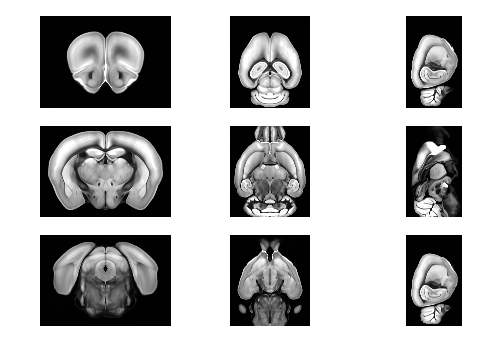

In [17]:
imgShow(refImg, vmax=500)

By examining the the z slices in the first column its clear that the x-axis goes from **R**ight to Left side of the brain. The y-axis varies from **S**uperior to Inferior and the z-axis goes from **A**nterior to posterior.  Thus it is in **RSA** orientation.  Looking at the the CLARITY brain...

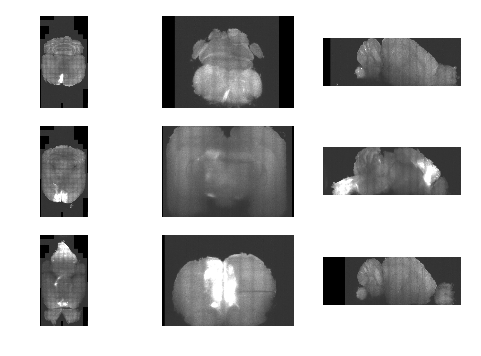

In [18]:
imgShow(inImg, vmax=500)

...we see that the x-axis goes from **R**eft to right, the y-axis goes from **P**nterior to Posterior and the Z axis goes from **S**nferior to Superior.  Thus it's in **RPS** orientation.  Therefore we reorient the CLARITY image from **RPS** to **RSA**

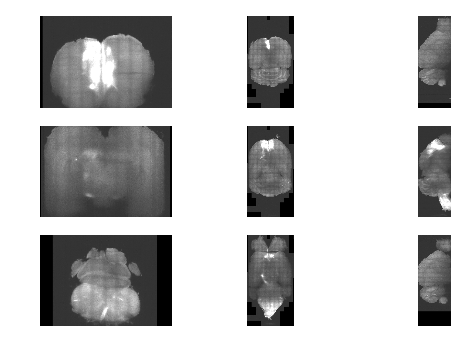

In [19]:
inImg = imgReorient(inImg, "RPS", "RSA")
imgShow(inImg, vmax=500)

Compare the above to the Atlas.  The slices should now correspond with the atlas.  Let's make a copy of this image as well because we'll need it later.

In [20]:
inImg_reorient = imgCopy(inImg)

## Thresholding CLARITY image
Lets plot the histogram of the CLARITY image

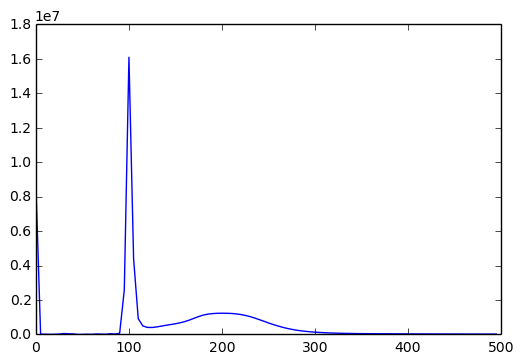

In [21]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

Notice the huge spike at 100.  This occurs because the intensity of the background is about 100. Idealy we want a black background with an intensity of 0.  Therefore we'll threhold the image below 100 and then subtract 100 from the image.

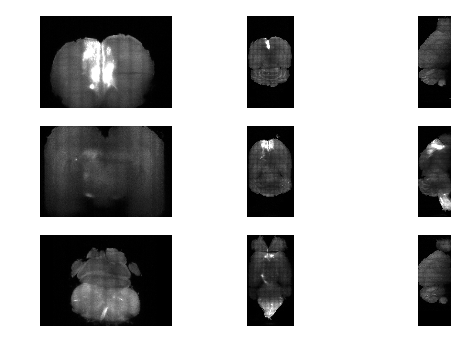

In [22]:
lowerThreshold = 100
upperThreshold = sitk.GetArrayFromImage(inImg).max()+1

inImg = sitk.Threshold(inImg,lowerThreshold,upperThreshold,lowerThreshold) - lowerThreshold
imgShow(inImg, vmax = 500)

Here's a histogram of the result

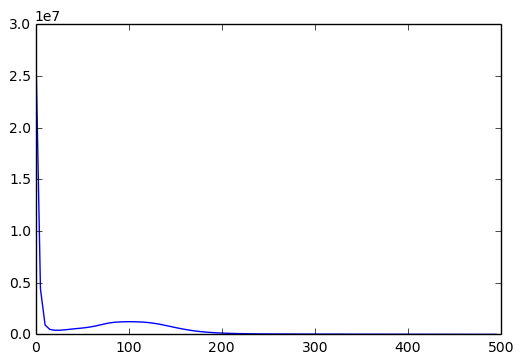

In [23]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

## Generating CLARITY mask
CLARITY brains contain really brignt fluorescent spots in the cerebral cortex and thalamus which can interfer with the registration.

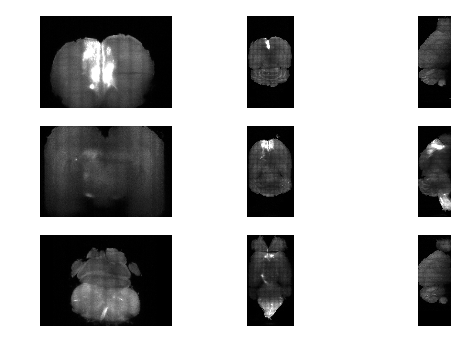

In [24]:
imgShow(inImg, vmax = 500)

To avoid this problem we create a mask which will be used to exclud the top 5% brighest voxels from registration.  To make the mask we first compute the normalized cumulative histogram.

In [25]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=1000)
cumValues = np.cumsum(values).astype(float)
cumValues = (cumValues - cumValues.min()) / cumValues.ptp()

We then find the first value greater than 0.95 (which is 100% - 5%)

In [26]:
maxIndex = np.argmax(cumValues>0.95)-1
threshold = bins[maxIndex]
print(threshold)

222.192


We then threshold the image using this value to obtain a mask

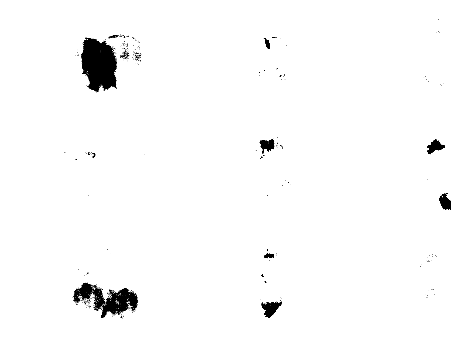

In [27]:
inMask = sitk.BinaryThreshold(inImg, 0, threshold, 1, 0)
imgShow(inMask)

The masked areas will be excluded from the registration

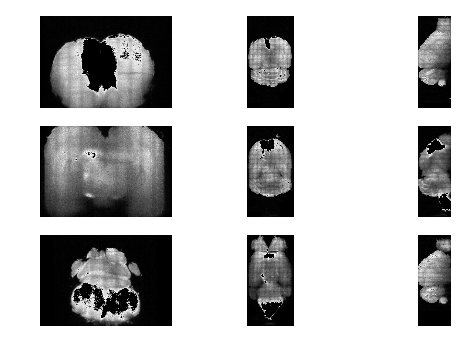

In [28]:
imgShow(imgMask(inImg,inMask))

## Affine Registration
We can finally begin the registration. Ideally we would do resgistration at the full atlas scale of 0.025 mm x 0.025 x 0.025 mm but this would be far to computationally expensive for the purposes of this tutorial.  Therefore to save time we downsample the images to 0.25 mm x 0.25mm x 0.25mm

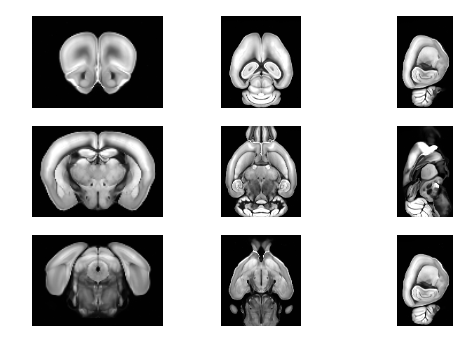

(114, 80, 132)


In [42]:
spacing=[0.1,0.1,0.1]
refImg_ds = imgResample(refImg, spacing=spacing)
imgShow(refImg_ds, vmax=500)
print(refImg_ds.GetSize())

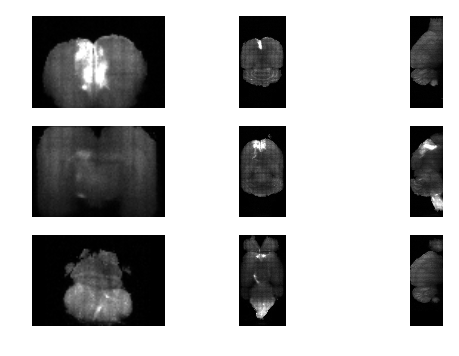

In [43]:
inImg_ds = imgResample(inImg, spacing=spacing)
imgShow(inImg_ds, vmax=500)

Notice how we used nearest-neighbor interpolation when downsampling the mask

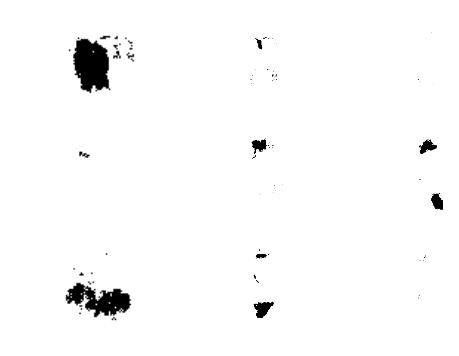

In [44]:
inMask_ds = imgResample(inMask, spacing=spacing, useNearest=True)
imgShow(inMask_ds)

Now we compute the affine transform.  Unlike in the [basic registration tutiorial](basicRegistration.ipynb) we'll use the *imgAffineComposite* instead of *imgAffine*.  *imgAffine* simply computes the affine transform between the input and reference images.  *imgAffineComposite* computes a translation then a rigid then an affine transformation.  It's output is the composition of those three transforms.  We use Mutual Information since the CLARITY and ARA images have very differnt intensity profiles.  We also enable the *verbose* option so that each iteration is printed.

In [45]:
affine = imgAffineComposite(inImg_ds, refImg_ds, inMask=inMask_ds, iterations=100, useMI=True, verbose=True)

Step translation:
0.	 -0.210204588078
1.	 -0.220357289646
2.	 -0.232332904938
3.	 -0.246583976981
4.	 -0.257918602474
5.	 -0.271973772927
6.	 -0.287374927692
7.	 -0.299691082109
8.	 -0.31736437693
9.	 -0.329358829203
10.	 -0.344718260445
11.	 -0.35835218927
12.	 -0.372655570891
13.	 -0.384687682436
14.	 -0.393669749013
15.	 -0.403226624156
16.	 -0.408222707141
17.	 -0.408754788501
18.	 -0.410025028181
19.	 -0.409253719499
20.	 -0.408635121132
21.	 -0.40978796579
22.	 -0.409068177725
23.	 -0.409449137237
24.	 -0.40977274245
25.	 -0.409698577548
26.	 -0.409759998626
Step rigid:
0.	 -0.421084752131
1.	 -0.341916183372
2.	 -0.43185608578
3.	 -0.417829719256
4.	 -0.453919248263
5.	 -0.455375615587
6.	 -0.462894592303
7.	 -0.459468023841
8.	 -0.463993533667
9.	 -0.466939695053
10.	 -0.466342846299
11.	 -0.468193778832
12.	 -0.469488944294
13.	 -0.470138802871
14.	 -0.471606712883
15.	 -0.471577038416
16.	 -0.473223669614
17.	 -0.473118074393
18.	 -0.473581218958
19.	 -0.474018911603
20.	 -0.

Now we apply the affine transform to the input CLARITY image and mask

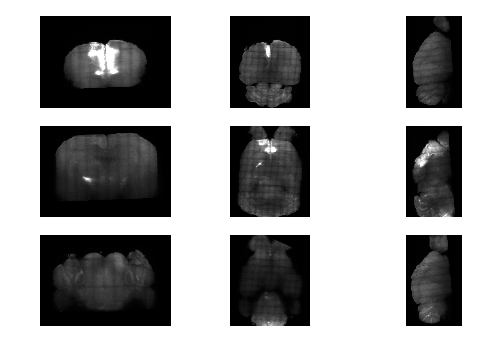

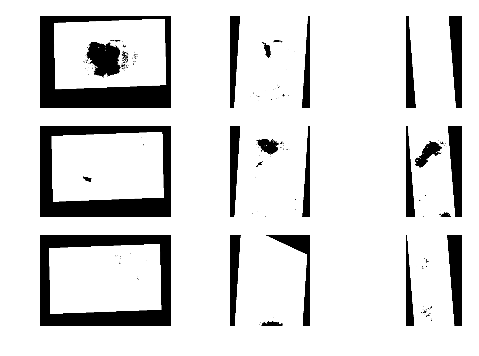

In [46]:
inImg_affine = imgApplyAffine(inImg, affine, size=refImg.GetSize())
imgShow(inImg_affine, vmax=500)

inMask_affine = imgApplyAffine(inMask, affine, size=refImg.GetSize(), useNearest=True)
imgShow(inMask_affine)

## LDDMM registration
Now we run LDDMM registration. Here we use *imgMetamorphosisComposite*.  Unlike *imgMetamorphosis* introduced in the [2D registration notebook](2D_Registration.ipynb), this function runs LDDMM in multiple steps using the alpha values specified by in *alphaList*. The *field* and *invField* outputs are the composition of all steps.  Once agan we use a Mutual Information cost because the input CLARITY brain and reference ARA average have very differnt intensity profiles.


Step 0: alpha=0.05, beta=0.05, scale=0.25
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-1.52655e+10, 1194.67, 0, -1.52655e+10 (99.4528%), 5.500000e-04
1.	-1.76478e+10, 1783.83, 0, -1.76478e+10 (96.3214%), 6.050000e-04
2.	-1.80445e+10, 2032.91, 0, -1.80445e+10 (95.7999%), 3.327500e-04
3.	-1.92767e+10, 2125.85, 0, -1.92767e+10 (94.1803%), 1.830125e-04
4.	-1.95348e+10, 2218.1, 0, -1.95348e+10 (93.841%), 1.006569e-04
5.	-1.98043e+10, 2300.76, 0, -1.98043e+10 (93.4868%), 1.107226e-04
6.	-1.98623e+10, 2357.9, 0, -1.98623e+10 (93.4106%), 6.089741e-05
7.	-2.00119e+10, 2431.2, 0, -2.00119e+10 (93.214%), 6.698715e-05
8.	-2.00964e+10, 2466.2, 0, -2.00964e+10 (93.1029%), 3.684293e-05
9.	-2.00997e+10, 2510.84, 0, -2.00997e+10 (93.0986%), 4.052723e-05
10.	-2.02529e+10, 2556.1, 0, -2.02529e+10 (92.8972%), 4.457995e-05
11.	-2.02758e+10, 2599.26, 0, -2.02758e+10 (92.867%), 4.903794e-05
12.	-2.02996e+10, 2657.85, 0, -2.02996e+10 (92.8357%), 5.394174e-05
13.	-2.03722e+10, 2739.87, 0, -2.

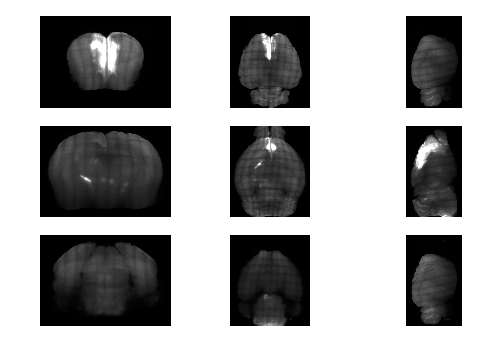

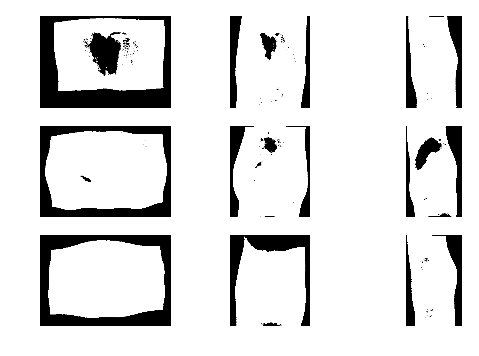

In [47]:
inImg_ds = imgResample(inImg_affine, spacing=spacing)
inMask_ds = imgResample(inMask_affine, spacing=spacing, useNearest=True)
(field, invField) = imgMetamorphosisComposite(inImg_ds, refImg_ds, inMask=inMask_ds, alphaList=[0.05, 0.02, 0.01], scaleList = [0.25, 0.5, 1.0], useMI=True, iterations=100, verbose=True)
inImg_lddmm = imgApplyField(inImg_affine, field, size=refImg.GetSize())
inMask_lddmm = imgApplyField(inMask_affine, field, size=refImg.GetSize(), useNearest=True)
imgShow(inImg_lddmm, vmax = 500)
imgShow(inMask_lddmm)

We can now overlay tha ARA annotaions on the CLARITY image.

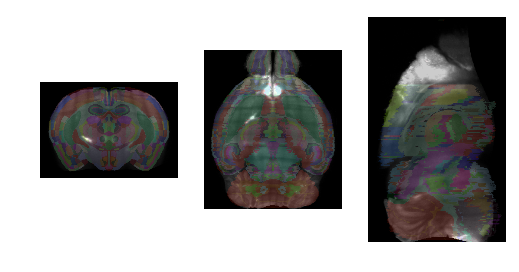

In [35]:
imgShow(inImg_lddmm, vmax=500, newFig=False, numSlices=1)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.2, newFig=False, numSlices=1)

## Evaluating the registration
### Evaluation using checker board
We can evaluate the registration by generating a checkerboard of the deformed CLARITY and ARA.  In this method the input image is placed on the black squares of the metaphorical checkerboard while the reference image is placed on the red squares.  Idealy anatomical sturctures should line up across squares.

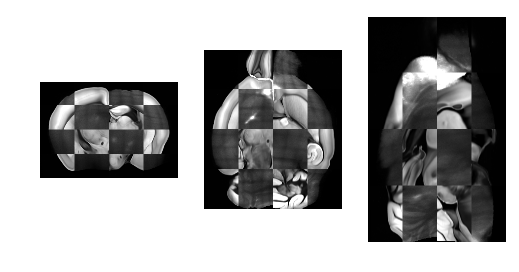

In [39]:
imgShow(imgChecker(inImg_lddmm, refImg, useHM=False), vmax=500, numSlices=1)
imgWrite(imgChecker(inImg_lddmm, refImg, useHM=False),"/cis/project/clarity/data/clarity/ailey/level5RSAiso/AutA_checker.img")

## Uploading Results
### Uploading deformed ARA annotations
Recall that we made a copy of the downloaded CLARITY image

In [ ]:
imgShow(inImg_download, vmax=500)

Recall that we also have ARA annotations

In [ ]:
imgShow(refAnnoImg, vmax=1000, cmap=randCmap)

Before we can overlay the ARA annotations on the downloaded image we must transfom them to its space. Fortunatly this can be done since all spatial transforms in this tutorial are invertable.  First we construct an inverse displacement field which transforms the annotations from the ARA space to the space before registration.

In [ ]:
invAffine = affineInverse(affine)
invAffineField = affineToField(invAffine, refImg.GetSize(), refImg.GetSpacing())
invField = fieldApplyField(invAffineField, invField)
inAnnoImg = imgApplyField(refAnnoImg, invField,useNearest=True, size=inImg_reorient.GetSize())
imgShow(inAnnoImg, vmax=1000, cmap=randCmap)

Were not done yet.  We still need to reorient these annotations from **RSA** to **LAI** 

In [ ]:
inAnnoImg = imgReorient(inAnnoImg, "RSA", "LAI")
imgShow(inAnnoImg, vmax=1000, cmap=randCmap)

Finally we resample the annotations to the spacing and size of the downloaded CLARITY image.  Lets look at the overlay.

In [ ]:
inAnnoImg = imgResample(inAnnoImg, spacing=inImg_download.GetSpacing(), size=inImg_download.GetSize(), useNearest=True)
imgShow(inImg_download, vmax=500, numSlices=1, newFig=False)
imgShow(inAnnoImg, vmax=1000, cmap=randCmap, alpha=0.2, numSlices=1, newFig=False)

We can upload these annotations at the lowest possible resolution.

In [ ]:
channel = "myAnnotationChannel"
imgUpload(inImg_lddmm, inToken, channel, resolution=5)

### Uploading deformed CLARITY image
We can also upload the ARA-aligned CLARITY brain back into ndstore.

In [ ]:
token = "myToken"
channel = "myChannel"
imgUpload(inImg_lddmm, token, channel)